# Подбор гиперпараметров с LighGBM + Optuna на примере предсказания задержки самолетов 

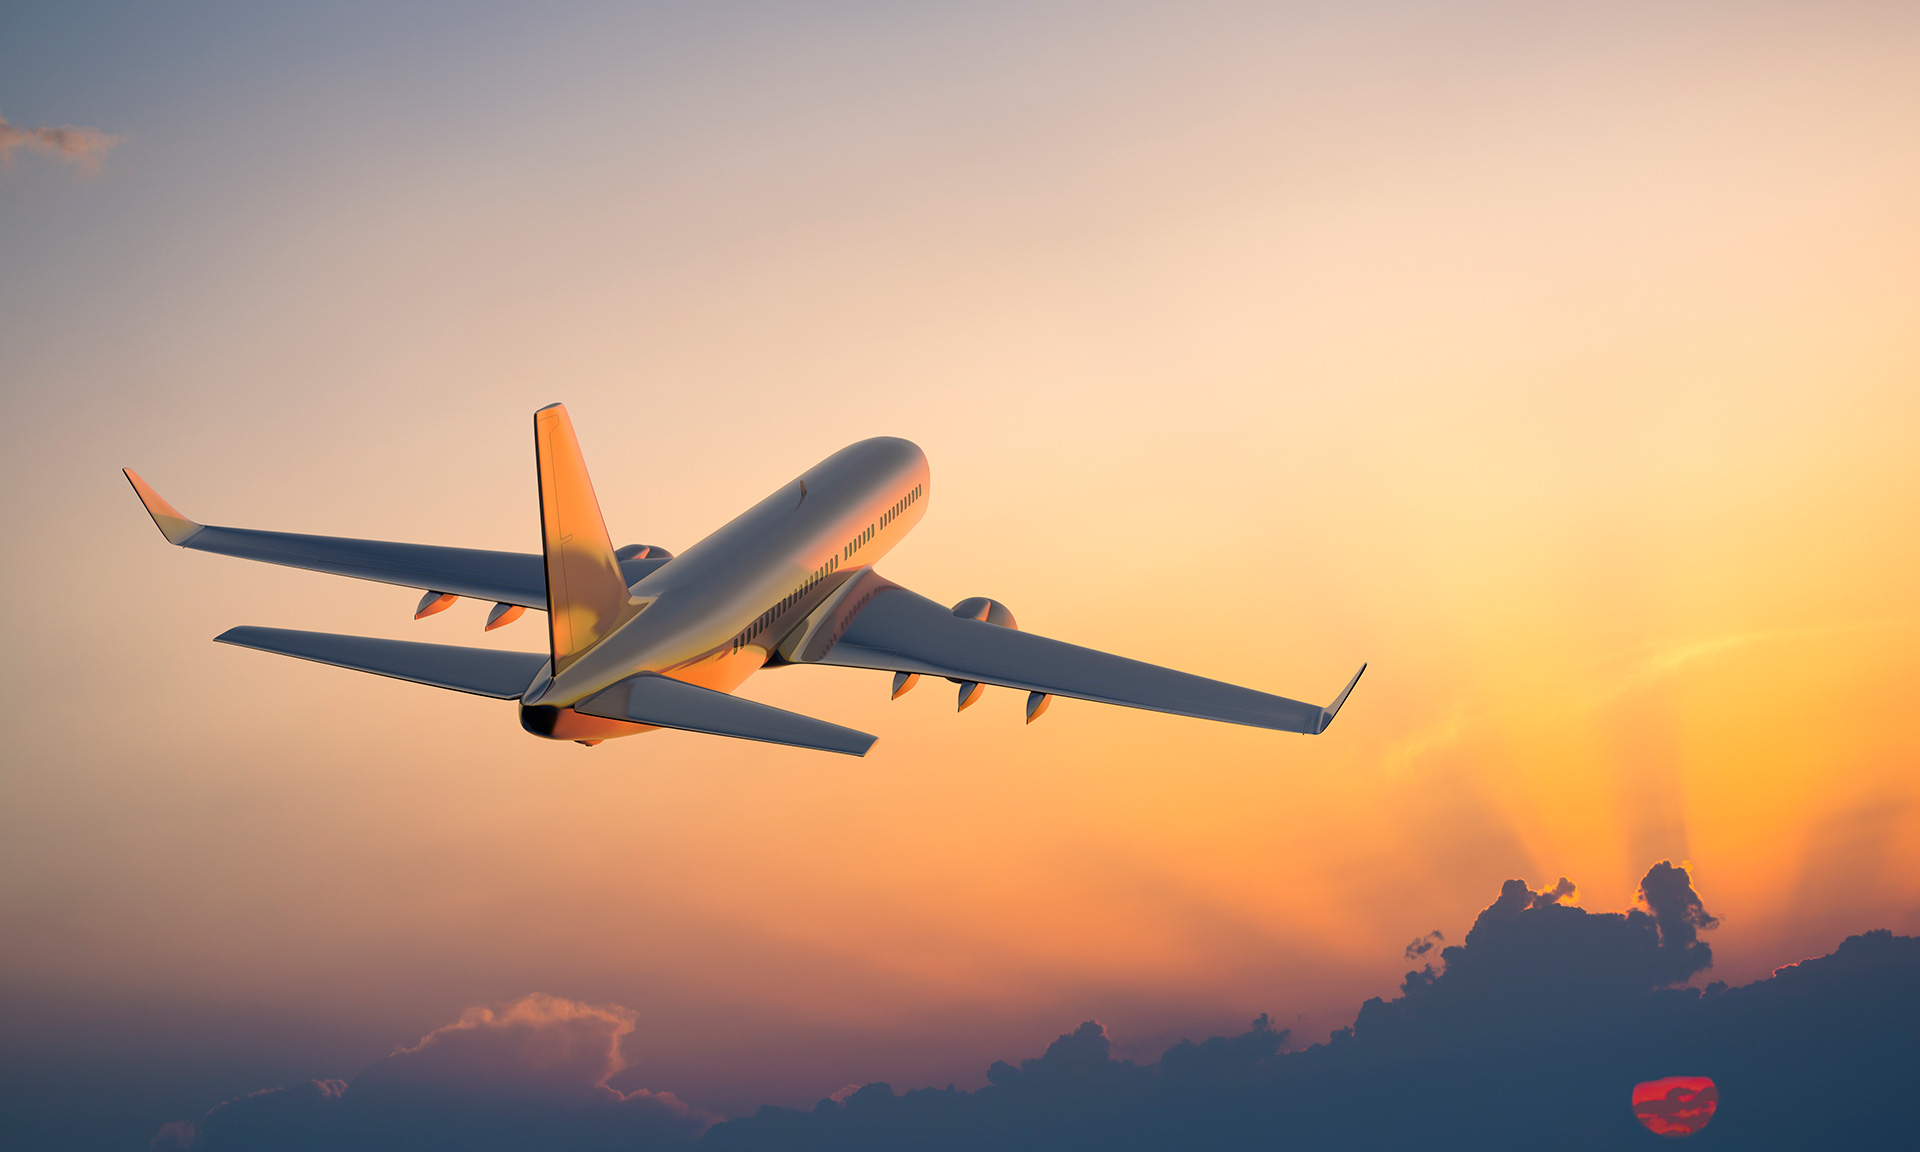

## Кроме модели LGBM воспользуемся Catboost. Сравнивать будем по метрике ROC-AUC

### Импорт библиотек и данных

In [1]:
!pip install catboost lightgbm optuna -q

In [98]:
!pip install ipywidgets -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
RANDOM_STATE = 111
DATASET_PATH = 'https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/flight_delays_train.csv'

In [100]:
df = pd.read_csv(DATASET_PATH)

In [101]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')

In [102]:
X = df.drop('dep_delayed_15min', axis = 1)
y = df['dep_delayed_15min'] == 'Y'

### Посмотрим на данные

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [104]:
df['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

<Axes: xlabel='UniqueCarrier', ylabel='count'>

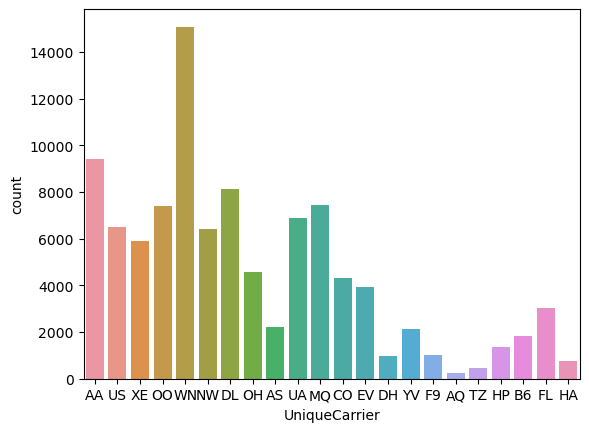

In [105]:
sns.countplot(data = df, x = df['UniqueCarrier'])

In [106]:
df['Distance'].describe()

count    100000.00000
mean        729.39716
std         574.61686
min          30.00000
25%         317.00000
50%         575.00000
75%         957.00000
max        4962.00000
Name: Distance, dtype: float64

### Выделим категориальные признаки в отдельную переменную

In [107]:
categorical_feature_indices = np.where(X.dtypes != 'int64')[0]
categorical_feature_indices

array([0, 1, 2, 4, 5, 6], dtype=int64)

In [108]:
len(categorical_feature_indices)

6

In [109]:
random_seed = 101

In [110]:
from catboost import CatBoostClassifier

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=random_seed)

In [113]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
34761,c-7,c-21,c-5,1906,WN,DAL,HOU,239
68319,c-5,c-18,c-3,858,AA,ORD,SAN,1723
76795,c-5,c-16,c-1,1426,US,ORF,PHL,211
4992,c-7,c-6,c-3,1650,EV,ATL,ROA,357
55717,c-9,c-4,c-1,836,CO,EWR,SNA,2433


### Применим CatBoostClassifier со стандартными гиперпараметрами 

In [120]:
model = CatBoostClassifier(random_seed= 101)

In [121]:
model.fit(X_train, y_train, cat_features=categorical_feature_indices)

Learning rate set to 0.065101
0:	learn: 0.6592398	total: 49ms	remaining: 49s
1:	learn: 0.6294317	total: 144ms	remaining: 1m 11s
2:	learn: 0.6056558	total: 185ms	remaining: 1m 1s
3:	learn: 0.5852345	total: 293ms	remaining: 1m 12s
4:	learn: 0.5668588	total: 349ms	remaining: 1m 9s
5:	learn: 0.5524590	total: 389ms	remaining: 1m 4s
6:	learn: 0.5384278	total: 498ms	remaining: 1m 10s
7:	learn: 0.5263155	total: 614ms	remaining: 1m 16s
8:	learn: 0.5168777	total: 654ms	remaining: 1m 12s
9:	learn: 0.5090778	total: 726ms	remaining: 1m 11s
10:	learn: 0.5025606	total: 767ms	remaining: 1m 8s
11:	learn: 0.4951410	total: 892ms	remaining: 1m 13s
12:	learn: 0.4889668	total: 1.02s	remaining: 1m 17s
13:	learn: 0.4838458	total: 1.12s	remaining: 1m 19s
14:	learn: 0.4796447	total: 1.22s	remaining: 1m 20s
15:	learn: 0.4769437	total: 1.24s	remaining: 1m 16s
16:	learn: 0.4726739	total: 1.35s	remaining: 1m 18s
17:	learn: 0.4700959	total: 1.46s	remaining: 1m 19s
18:	learn: 0.4664794	total: 1.59s	remaining: 1m 22s


In [126]:
base_preds = model.predict_proba(X_test)[:,1]

In [114]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [115]:
from catboost.utils import get_roc_curve

In [129]:
roc_auc_score(y_test, base_preds)

0.7701633586472791

### Получили ROC-AUC 0.77 с базовыми параметрами. Попробуем LightGBM

In [116]:
from lightgbm import LGBMClassifier

In [117]:
model = LGBMClassifier(random_state=random_seed)

In [118]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

In [119]:
categorical_feature_indices = np.where(X.dtypes != 'int64')[0]
categorical_feature_indices

array([0, 1, 2, 4, 5, 6], dtype=int64)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=random_seed)

In [152]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14243, number of negative: 60757
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189907 -> initscore=-1.450617
[LightGBM] [Info] Start training from score -1.450617


LGBMClassifier(random_state=101)

In [155]:
base_preds = model.predict_proba(X_test)[:,1]

In [158]:
rocscore = roc_auc_score(y_test, base_preds)

In [82]:
round(rocscore, 2)

NameError: name 'rocscore' is not defined

### Получили ROC-AUC 0.74 с базовыми параметрами. Попробуем увеличить скор  с помощью гиперпараметров. Используем Optuna

In [121]:
from sklearn.model_selection import cross_val_score

In [122]:
import optuna 

In [123]:
Xtrain_new, Xval, ytrain_new, yval = train_test_split(X_train, y_train, test_size=0.25, random_state=random_seed)

In [124]:
Xtrain_new.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
33974,c-10,c-19,c-3,2010,WN,MDW,STL,251
43330,c-7,c-30,c-6,625,WN,MCO,BNA,616
59484,c-8,c-16,c-2,2127,XE,IAH,MSP,1034
97334,c-10,c-13,c-4,1806,XE,TUL,IAH,429
97882,c-6,c-3,c-5,800,OH,TYS,CVG,226


In [26]:
!pip install itables

  Obtaining dependency information for itables from https://files.pythonhosted.org/packages/66/fa/a5d6ab37ec4acf15549548ecf7c910c4270370060c5bf0f8e49c275f54dc/itables-1.5.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/199.4 kB ? eta -:--:--
   ------ --------------------------------- 30.7/199.4 kB ? eta -:--:--
   ------------------ --------------------- 92.2/199.4 kB 1.3 MB/s eta 0:00:01
   -------------------------------- ------- 163.8/199.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 199.4/199.4 kB 1.2 MB/s eta 0:00:00


### Интересный плагин для кастомизации вывода таблиц, можно иногда использовать, когда хочется чего-то более наглядного 😄

In [125]:
from IPython.display import display, HTML

In [126]:
def display_table(df: pd.DataFrame):
    """
    Helper function
    Wraps the styles and returns the fancy dataframe
    """
    tem_df = df
    tem_df = tem_df.style.set_table_styles(styles)
    return tem_df


BASE_COLOR = "#F96167"
styles = [
    dict(
        selector="th",
        props=[
            ("font-size", "11pt"),
            ("background-color", f"{BASE_COLOR}"),
            ("padding", "12px 35px"),
            ("border-collapse", "collapse"),
            ("color", "white"),
            ("font-weight", "bold"),
            ("border-bottom", "0.1px solid white"),
            ("border-left", "0.1px solid white"),
            ("text-align", "center"),
            ("text-transform", "uppercase"),
        ],
    ),
    dict(
        selector="th:hover",
        props=[
            ("font-size", "14pt"),
            ("background-color", f"{BASE_COLOR}"),
        ],
    ),
    dict(
        selector="th:hover span tr:hover span",
        props=[
            ("font-size", "14pt"),
            ("color", "#FFFFD2"),
        ],
    ),
    dict(
        selector="tr:hover th",
        props=[
            ("font-size", "14pt"),
            ("background-color", f"{BASE_COLOR}"),
        ],
    ),
    dict(
        selector="td",
        props=[
            ("padding", "0.5em 1em"),
            ("text-align", "center"),
            ("font-size", "14px"),
        ],
    ),
    dict(
        selector="tr:hover td:hover",
        props=[
            ("max-width", "250px"),
            ("font-size", "14pt"),
            ("color", "#e91013E"),
            ("font-weight", "bold"),
            ("background-color", "white"),
            ("border", f"1px dashed {BASE_COLOR}"),
        ],
    ),
    dict(
        selector="table",
        props=[
            ("font-family", "Georgia"),
            ("margin", "25px auto"),
            ("border-collapse", "collapse"),
            ("border", "1px solid #eee"),
            ("border-bottom", "2px solid #00cccc"),
        ],
    ),
    dict(
        selector="caption",
        props=[(("caption-side", "bottom"))],
    ),
]
print("DONE")

DONE


In [127]:
display_table(Xtrain_new[:10])

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
33974,c-10,c-19,c-3,2010,WN,MDW,STL,251
43330,c-7,c-30,c-6,625,WN,MCO,BNA,616
59484,c-8,c-16,c-2,2127,XE,IAH,MSP,1034
97334,c-10,c-13,c-4,1806,XE,TUL,IAH,429
97882,c-6,c-3,c-5,800,OH,TYS,CVG,226
52671,c-5,c-17,c-3,1726,XE,EWR,RIC,278
60581,c-1,c-19,c-4,1357,OH,CVG,IAH,871
27943,c-7,c-18,c-2,1557,US,PHL,ORD,678
90796,c-11,c-8,c-2,1206,CO,EWR,IAH,1400
18675,c-11,c-13,c-7,1425,WN,BDL,TPA,1111


In [128]:
new_cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']
new_cat_features

['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

In [153]:
def objective_lgbm(trial):
    params = {
        'random_state' : 101,
        'n_jobs' : -1,
        'num_leaves' : trial.suggest_int("num_leaves", 10, 100),
        'n_estimators' : trial.suggest_int("n_estimators", 10, 1000)
    }
    
    model_first = LGBMClassifier(**params)
    model_first.fit(Xtrain_new, ytrain_new, eval_set=(Xval, yval), categorical_feature= new_cat_features) 
    score = roc_auc_score(y_test, model_first.predict_proba(X_test)[:,1])
    return score

In [154]:
study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed = 101))
study.optimize(objective_lgbm, n_trials=30)

[I 2023-09-18 12:29:12,233] A new study created in memory with name: no-name-944de03b-3b6b-44f1-99a0-fdad03ad578f


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:13,353] Trial 0 finished with value: 0.7280932455869555 and parameters: {'num_leaves': 56, 'n_estimators': 575}. Best is trial 0 with value: 0.7280932455869555.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:13,594] Trial 1 finished with value: 0.7363810640263517 and parameters: {'num_leaves': 12, 'n_estimators': 179}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:15,784] Trial 2 finished with value: 0.7287925157183421 and parameters: {'num_leaves': 72, 'n_estimators': 836}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:17,308] Trial 3 finished with value: 0.7248987034330222 and parameters: {'num_leaves': 37, 'n_estimators': 895}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:18,076] Trial 4 finished with value: 0.7321624941187405 and parameters: {'num_leaves': 75, 'n_estimators': 198}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:19,278] Trial 5 finished with value: 0.7304006967787778 and parameters: {'num_leaves': 60, 'n_estimators': 358}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:20,867] Trial 6 finished with value: 0.7249398891362128 and parameters: {'num_leaves': 26, 'n_estimators': 788}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:21,996] Trial 7 finished with value: 0.7313287465824193 and parameters: {'num_leaves': 97, 'n_estimators': 240}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:22,993] Trial 8 finished with value: 0.7269089864739818 and parameters: {'num_leaves': 17, 'n_estimators': 608}. Best is trial 1 with value: 0.7363810640263517.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:24,026] Trial 9 finished with value: 0.7309437726572282 and parameters: {'num_leaves': 76, 'n_estimators': 283}. Best is trial 1 with value: 0.7363810640263517.
[I 2023-09-18 12:29:24,175] Trial 10 finished with value: 0.7365840484966708 and parameters: {'num_leaves': 40, 'n_estimators': 24}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117
[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [In

[I 2023-09-18 12:29:24,271] Trial 11 finished with value: 0.7307487644366384 and parameters: {'num_leaves': 37, 'n_estimators': 11}. Best is trial 10 with value: 0.7365840484966708.
[I 2023-09-18 12:29:24,362] Trial 12 finished with value: 0.7267879918699794 and parameters: {'num_leaves': 11, 'n_estimators': 14}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117
[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.44211

[I 2023-09-18 12:29:24,671] Trial 13 finished with value: 0.7357110951407377 and parameters: {'num_leaves': 37, 'n_estimators': 98}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:25,509] Trial 14 finished with value: 0.7277077766908697 and parameters: {'num_leaves': 25, 'n_estimators': 424}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:26,083] Trial 15 finished with value: 0.7352485551516008 and parameters: {'num_leaves': 47, 'n_estimators': 169}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:26,888] Trial 16 finished with value: 0.7306515851509927 and parameters: {'num_leaves': 24, 'n_estimators': 445}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:27,275] Trial 17 finished with value: 0.7345066865875953 and parameters: {'num_leaves': 46, 'n_estimators': 107}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:27,693] Trial 18 finished with value: 0.7341096116552199 and parameters: {'num_leaves': 11, 'n_estimators': 342}. Best is trial 10 with value: 0.7365840484966708.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:28,056] Trial 19 finished with value: 0.7365932363939023 and parameters: {'num_leaves': 32, 'n_estimators': 128}. Best is trial 19 with value: 0.7365932363939023.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:30,648] Trial 20 finished with value: 0.7299909124374935 and parameters: {'num_leaves': 63, 'n_estimators': 996}. Best is trial 19 with value: 0.7365932363939023.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:30,948] Trial 21 finished with value: 0.7370330283456735 and parameters: {'num_leaves': 29, 'n_estimators': 120}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:31,244] Trial 22 finished with value: 0.7351387231724614 and parameters: {'num_leaves': 46, 'n_estimators': 87}. Best is trial 21 with value: 0.7370330283456735.
[I 2023-09-18 12:29:31,347] Trial 23 finished with value: 0.7289845902051921 and parameters: {'num_leaves': 32, 'n_estimators': 10}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117
[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.44211

[I 2023-09-18 12:29:31,909] Trial 24 finished with value: 0.7308898105178202 and parameters: {'num_leaves': 31, 'n_estimators': 282}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:32,349] Trial 25 finished with value: 0.7336464890440925 and parameters: {'num_leaves': 50, 'n_estimators': 135}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:33,649] Trial 26 finished with value: 0.7287673443859717 and parameters: {'num_leaves': 41, 'n_estimators': 629}. Best is trial 21 with value: 0.7370330283456735.
[I 2023-09-18 12:29:33,861] Trial 27 finished with value: 0.736298651372396 and parameters: {'num_leaves': 21, 'n_estimators': 89}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117
[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [In

[I 2023-09-18 12:29:34,346] Trial 28 finished with value: 0.7331179735594591 and parameters: {'num_leaves': 33, 'n_estimators': 236}. Best is trial 21 with value: 0.7370330283456735.


[LightGBM] [Info] Number of positive: 10756, number of negative: 45494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191218 -> initscore=-1.442117
[LightGBM] [Info] Start training from score -1.442117


[I 2023-09-18 12:29:36,016] Trial 29 finished with value: 0.7289378412353837 and parameters: {'num_leaves': 55, 'n_estimators': 547}. Best is trial 21 with value: 0.7370330283456735.


In [131]:
study.best_params

{'num_leaves': 29, 'n_estimators': 120}

In [132]:
best_trial = study.best_trial.params
best_trial

{'num_leaves': 29, 'n_estimators': 120}

In [133]:
optuna.visualization.plot_param_importances(study)

In [134]:
#Просмотр по продолжительности подбора гиперпараметров Optuna
optuna.visualization.plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")

In [136]:
round(study.best_value, 5)

0.73703

### SCORE = 0.73703 на тесте. Попробуем увеличить с помощью большего количества итераций Optuna + подбора других гиперпараметров. Особенно интересными тут будут learning rate и max_depth

In [138]:
def back_to_start():
    RANDOM_STATE = 111
    DATASET_PATH = 'https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/flight_delays_train.csv'
    df = pd.read_csv(DATASET_PATH)
    X = df.drop('dep_delayed_15min', axis = 1)
    y = df['dep_delayed_15min'] == 'Y'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=random_seed)
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')
    categorical_feature_indices = np.where(X.dtypes != 'int64')[0]
    categorical_feature_indices
    Xtrain_new, Xval, ytrain_new, yval = train_test_split(X_train, y_train, test_size=0.25, random_state=random_seed)
    new_cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

In [227]:
back_to_start()

In [217]:
def objective_lgbm(trial):
    params = {
        'random_state' : 101,
        'n_jobs' : -1,
        'verbose':-1,
        'num_leaves' : trial.suggest_int("num_leaves", 3, 1000),
        'n_estimators' : trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_categorical("max_depth", [25, 10, 12, 20, 40, 100, -1]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 20.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        
    }
    
    model_first = LGBMClassifier(**params)
    model_first.fit(Xtrain_new, ytrain_new, eval_set=(Xval, yval), categorical_feature= new_cat_features) 
    score = roc_auc_score(y_test, model_first.predict_proba(X_test)[:,1])
    return score


In [218]:
study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed = 101))
study.optimize(objective_lgbm, n_trials=500)

[I 2023-09-18 14:12:14,754] A new study created in memory with name: no-name-49b3bfc3-2a85-464d-a3e4-d70c00081c67
[I 2023-09-18 14:12:17,367] Trial 0 finished with value: 0.7405331944032527 and parameters: {'num_leaves': 518, 'n_estimators': 575, 'max_depth': 100, 'learning_rate': 0.09505048320697791, 'reg_alpha': 0.5546733635336624, 'reg_lambda': 7.043286948578256, 'colsample_bytree': 0.345513922128063, 'subsample': 0.8713610571186152, 'min_child_samples': 290, 'min_data_per_groups': 24}. Best is trial 0 with value: 0.7405331944032527.
[I 2023-09-18 14:12:19,719] Trial 1 finished with value: 0.7195887484824888 and parameters: {'num_leaves': 86, 'n_estimators': 608, 'max_depth': 25, 'learning_rate': 0.4971595187869331, 'reg_alpha': 0.521144731288282, 'reg_lambda': 11.576211919972861, 'colsample_bytree': 0.7878552466155055, 'subsample': 0.7251770633377561, 'min_child_samples': 274, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.7405331944032527.
[I 2023-09-18 14:12:21,383] Tr

In [219]:
study.best_params

{'num_leaves': 448,
 'n_estimators': 543,
 'max_depth': 100,
 'learning_rate': 0.018481891721347787,
 'reg_alpha': 0.0026754741237161473,
 'reg_lambda': 0.7129115202207377,
 'colsample_bytree': 0.6573680912914133,
 'subsample': 0.784497443059972,
 'min_child_samples': 16,
 'min_data_per_groups': 100}

In [221]:
study.best_value

0.7644487546784932

### Скор получилось поднять. Попробуем подобрать гиперпараметры еще раз, но с boosting_type = dart. Плюс можно посмотреть на визуализацию важности гиперпараметров 

#### SCORE = 0.751683609984425
{'num_leaves': 83,
 'n_estimators': 9160,
 'max_depth': 11,
 'learning_rate': 0.0710435374913615}
 
 {'num_leaves': 916,
 'n_estimators': 841,
 'max_depth': 40,
 'learning_rate': 0.05615249885661677,
 'reg_alpha': 0.0023164776165542147,
 'reg_lambda': 0.055533212245059166}
 
 SCORE = 0.751683609984425
 
 {'num_leaves': 86,
 'n_estimators': 319,
 'max_depth': -1,
 'learning_rate': 0.04429937954674562,
 'reg_alpha': 2.8761885582625935,
 'reg_lambda': 7.265025744591701,
 'colsample_bytree': 0.5739204609397638,
 'subsample': 0.6656421436297949,
 'min_child_samples': 202,
 'min_data_per_groups': 58}
 
 SCORE = 0.7530051513374025
 
 {'num_leaves': 239,
 'n_estimators': 431,
 'max_depth': 20,
 'learning_rate': 0.04084115733003606,
 'reg_alpha': 4.024332514739822,
 'reg_lambda': 7.4746247336394696,
 'colsample_bytree': 0.6442226966727665,
 'subsample': 0.49782605850455286,
 'min_child_samples': 240,
 'min_data_per_groups': 59}
 
 SCORE = 0.7539433996038521
 
 {'num_leaves': 339,
 'n_estimators': 626,
 'max_depth': 20,
 'learning_rate': 0.034648078461988537,
 'reg_alpha': 0.001664385181302741,
 'reg_lambda': 8.408099911923129,
 'colsample_bytree': 0.6813716901688198,
 'subsample': 0.45537610483098345,
 'min_child_samples': 5,
 'min_data_per_groups': 61}
 
 SCORE = 0.7594484452701246
 
 {'num_leaves': 448,
 'n_estimators': 543,
 'max_depth': 100,
 'learning_rate': 0.018481891721347787,
 'reg_alpha': 0.0026754741237161473,
 'reg_lambda': 0.7129115202207377,
 'colsample_bytree': 0.6573680912914133,
 'subsample': 0.784497443059972,
 'min_child_samples': 16,
 'min_data_per_groups': 100}
 
 SCORE = 0.7644487546784932
 
 {
 'boosting_type': 'dart',
        'random_state' : 101,
        'n_jobs' : -1,
        'verbose':-1,
 'num_leaves': 835,
 'n_estimators': 974,
 'max_depth': 25,
 'learning_rate': 0.05006083483771309,
 'reg_alpha': 0.9612943264220698,
 'reg_lambda': 0.34574105938448785,
 'colsample_bytree': 0.8086379101001601,
 'subsample': 0.8595136164926187,
 'min_child_samples': 3,
 'min_data_per_groups': 93}
 
 SCORE = 0.7647220095480092
 

In [222]:
optuna.visualization.plot_param_importances(study)

In [179]:
optuna.visualization.plot_param_importances(study)

In [228]:
def objective_lgbm(trial):
    params = {
        'boosting_type': 'dart',
        'random_state' : 101,
        'n_jobs' : -1,
        'verbose':-1,
        'num_leaves' : trial.suggest_int("num_leaves", 3, 1000),
        'n_estimators' : trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_categorical("max_depth", [25, 10, 12, 20, 40, 100, -1]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 20.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        
    }
    
    model_first = LGBMClassifier(**params)
    model_first.fit(Xtrain_new, ytrain_new, eval_set=(Xval, yval), categorical_feature= new_cat_features) 
    score = roc_auc_score(y_test, model_first.predict_proba(X_test)[:,1])
    return score

In [229]:
study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed = 101))
study.optimize(objective_lgbm, n_trials=100)

[I 2023-09-18 15:40:16,507] A new study created in memory with name: no-name-fc4337b5-8eb5-4f29-ba8d-6ff98c49ca0e
[I 2023-09-18 15:40:26,578] Trial 0 finished with value: 0.744152318465841 and parameters: {'num_leaves': 518, 'n_estimators': 575, 'max_depth': 100, 'learning_rate': 0.038068796945538885, 'reg_alpha': 0.5546733635336624, 'reg_lambda': 7.043286948578256, 'colsample_bytree': 0.345513922128063, 'subsample': 0.8713610571186152, 'min_child_samples': 290, 'min_data_per_groups': 24}. Best is trial 0 with value: 0.744152318465841.
[I 2023-09-18 15:40:37,227] Trial 1 finished with value: 0.7353088075461284 and parameters: {'num_leaves': 86, 'n_estimators': 608, 'max_depth': 25, 'learning_rate': 0.198864148440704, 'reg_alpha': 0.521144731288282, 'reg_lambda': 11.576211919972861, 'colsample_bytree': 0.7878552466155055, 'subsample': 0.7251770633377561, 'min_child_samples': 274, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.744152318465841.
[I 2023-09-18 15:40:42,128] Trial

In [230]:
study.best_params

{'num_leaves': 835,
 'n_estimators': 974,
 'max_depth': 25,
 'learning_rate': 0.05006083483771309,
 'reg_alpha': 0.9612943264220698,
 'reg_lambda': 0.34574105938448785,
 'colsample_bytree': 0.8086379101001601,
 'subsample': 0.8595136164926187,
 'min_child_samples': 3,
 'min_data_per_groups': 93}

In [231]:
study.best_value

0.7647220095480092

In [234]:
optuna.visualization.plot_param_importances(study)

In [236]:
from sklearn.model_selection import cross_val_score, KFold

In [281]:
back_to_start()

In [282]:
params = study.best_params
params['boosting_type'] = 'dart'
params['random_state'] = 101
params['n_jobs'] = -1
params['verbose'] = -1


In [279]:
model = LGBMClassifier(**params)

In [283]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.8086379101001601,
               learning_rate=0.05006083483771309, max_depth=25,
               min_child_samples=3, min_data_per_groups=93, n_estimators=974,
               n_jobs=-1, num_leaves=835, random_state=101,
               reg_alpha=0.9612943264220698, reg_lambda=0.34574105938448785,
               subsample=0.8595136164926187, verbose=-1)

In [284]:
preds = model.predict_proba(X_test)[:,1]

In [285]:
score = roc_auc_score(y_test, preds)

In [286]:
score

0.7591079981016629

In [289]:
round(score, 2)

0.76